# Numerical Modeling, Term 3, 2023

### Problem 1 (Image Processing) (40pt)

Let us consider a problem of denoising a color image, by solving the following PDE:
$$
\begin{align*}
\frac{\partial}{\partial t} u _i &= {\rm div} (\nabla u _i) + \lambda (u^{(0)}-u _i) \\
u _i|_{t=0} &= u^{(0)} _i \\
u _i| _{\partial\Omega} &= u^{(0)} _i| _{\partial\Omega} \\
\end{align*}
$$
where $u_i$, $i=1,2,3$, is the intensity of the red, green, and blue components of the image;
$u^{(0)}_i$ represents the original image.
The parameter $\lambda$ should be inversely proportional to the level of noise, and can be taken, for a start, as 1/100 or 1/200.
The time of integration should be taken so that we can approximate a steady-state solution.

* Take a noisy image from <a href="https://github.com/oseledets/fastpde/blob/master/fig/color_photo_noisy.png">here</a> or generate it yourself. (If you generate yourself then make the noise level to be 64 out of 256.)

* **(10pt)** Write a code that solves the system

In [4]:
from ipywidgets import interact
from PIL import Image
import numba as nb
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyamg
import numpy as np
import matplotlib.pyplot as plt

def display_img_array(ima):
    plt.imshow(ima)

def error(a,b):
    return np.sqrt(np.mean(np.abs(a**2 - b**2)))

def solve(img_orig, t, l):
    A = sp.sparse.csr_matrix(pyamg.gallery.laplacian.poisson(img_orig[:,:,0].shape))
    vec0 = img_orig.reshape(-1,1,3)
    vec_prev = vec0.copy()
    err_prev = 0
    err_next = 1
    delta = 10**(-3)
    vec_next = vec0.copy()
    while np.abs(err_next - err_prev) > delta:
        if err_next > 100:
            break
        
        err_prev = err_next
        for i in range(3):
            vec_next[:,:,i] += -t*A @vec_prev[:,:,i] + t*l*(vec0[:,:,i] - vec_prev[:,:,i])
        imarray = vec_next.reshape(img.shape);
        imarray[0,:,:] = img_orig[0,:,:]
        imarray[-1,:,:] = img_orig[-1,:,:]
        imarray[:,-1,:] = img_orig[:,-1,:]
        imarray[:,0,:] = img_orig[:,0,:]
        vec_next = imarray.reshape(-1,1,3)
        err_next = error(vec_prev, vec_next)
        vec_prev = vec_next.copy()
    return imarray

t = 0.025
l = 1/200
img = plt.imread('color_photo_noisy.png', format='png')
img_den = solve(img, t,l)
print(img_den.shape)
def set_cursor(i):
    if i==0:
        display_img_array(img)
    else:
        display_img_array(img_den)

interact(set_cursor, i=(0, 1))

(612, 816, 3)


interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

<function __main__.set_cursor(i)>

* **(10pt)** Set $\lambda=1/200$ and try getting some results with $\tau=0.025$, $\tau=0.25$, and  $\tau=2.5$. Comment on the results and explain them.

In [5]:
l = 1/200
ts = [0.025, 0.25, 2.5]
img_den = np.empty((3,612,816,3))
for ind, t in enumerate(ts):
    img_den[ind] = solve(img, t,l)
print(img_den.shape)
def set_cursor(i):
    if i==0:
        display_img_array(img)
    elif i == 1:
        display_img_array(img_den[0])
    elif i == 2:
        display_img_array(img_den[1])
    else:
        display_img_array(img_den[2])

interact(set_cursor, i=(0,3,1))

(3, 612, 816, 3)


interactive(children=(IntSlider(value=1, description='i', max=3), Output()), _dom_classes=('widget-interact',)…

<function __main__.set_cursor(i)>

First of all we should analyze stability. Let $u(t,x,y) = f(t)e^{i(k_xx+k_yy)}$. If we substitute it to our discretized equation and assume that $\left|\dfrac{f(t+\tau)}{f(t)}\right| \leq 1$ we'll get
$$
\tau \leq \frac{2}{8 + \lambda(1-\xi)},
$$
where $\xi = \dfrac{f(0)}{f(t)} \geq 1$.

If $\xi = 1$, $\tau \leq 0.25$. That's why when $\tau$ is much larger then $0.25$ it leads to unstability. Vice versa if $\tau$ is much smaller then $0.25$ it leads to stable algorithm.

Let us consider a more advanced approach:
$$
\begin{align*}
\frac{\partial}{\partial t} u _i &= {\rm div} (k \nabla u _i) + \lambda (u^{(0)}-u _i) \\
u _i|_{t=0} &= u^{(0)} _i \\
u _i| _{\partial\Omega} &= u^{(0)} _i| _{\partial\Omega} \\
\end{align*}
$$
where now $k=\big(1 + \max_i |\nabla u_i|^2\big)^{-1/2}$.

* **(10pt)** Write a code that solves the system

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation

img = plt.imread('color_photo_noisy.png')

@nb.jit(nopython=True)
def time_step(im, im_orig, l, t):
    new_imarray = im.copy()
    for i in range(1,im.shape[0]-2):
        for j in range(1,im.shape[1]-2):
            dx1 = np.empty(3)
            dx0 = np.empty(3)
            dx = np.empty(3)
            dy1 = np.empty(3)
            dy0 = np.empty(3)
            dy = np.empty(3)
            k1,k2,k3,k4 = np.empty((4,3))
            for k in range(3):
                dx1[k] = im[i+1,j,k]-im[i,j,k]
                dx0[k] = im[i,j,k]-im[i-1,j,k]
                dx[k] = (dx1[k]+dx0[k])/2
                dy1[k] = im[i,j+1,k]-im[i,j,k]
                dy0[k] = im[i,j,k]-im[i,j-1,k]
                dy[k] = (dy0[k]+dy1[k])/2
                k1[k] = dx1[k]*dx1[k]+dy[k]*dy[k]
                k2[k] = dx0[k]*dx0[k]+dy[k]*dy[k]
                k3[k] = dy1[k]*dy1[k]+dx[k]*dx[k]
                k4[k] = dy0[k]*dy0[k]+dx[k]*dx[k]
            k1 = k1.max()
            k2 = k2.max()
            k3 = k3.max()
            k4 = k4.max()
            new_imarray[i,j,:] += t*(dx1/np.sqrt(1+k1)-dx0/np.sqrt(1+k2))
            new_imarray[i,j,:] += t*(dy1/np.sqrt(1+k3)-dy0/np.sqrt(1+k4))
    new_imarray += t*l*(im_orig - im)
    return new_imarray


l = 1/200
t = 0.15
err_prev = 0
err_next = 1
delta = 10**(-2)
imarray_prev = img.copy()
while np.abs(err_next - err_prev) > delta:
    if err_next > 100:
        break
    err_next = err_prev
    imarray_next = time_step(imarray_prev, img, l, t)
    err_prev = error(imarray_prev, imarray_next)
    imarray_prev = imarray_next.copy()
    
def set_cursor(i):
    if i == 0:
        display_img_array(img)
    else:
        display_img_array(imarray_next)

interact(set_cursor, i=(0, 1))

interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

<function __main__.set_cursor(i)>

* **(10pt)** Give results for three values of $\lambda$, for which the final image is (1) Too noisy, (2) Too blurry, (3) About right

In [10]:
ls = [1/1000,1/10,1]
t = 0.1
delta = 10**(-3)
imgs_denoized = []
for l in ls:
    err_prev = 0
    err_next = 1
    img = plt.imread('color_photo_noisy.png')
    imarray_prev = img.copy()
    while np.abs(err_next - err_prev) > delta:
        err_next = err_prev
        imarray_next = time_step(imarray_prev, img, l, t)
        err_prev = error(imarray_prev, imarray_next)
        imarray_prev = imarray_next.copy()
    imgs_denoized.append(imarray_next.copy())
def set_cursor(i):
    display_img_array(imgs_denoized[i])
    

interact(set_cursor, i=(0, len(ls)-1,1))

interactive(children=(IntSlider(value=1, description='i', max=2), Output()), _dom_classes=('widget-interact',)…

<function __main__.set_cursor(i)>

* Too noisy, when $\lambda \approx 0.001$
* Too blurry, when $\lambda \approx 1$
* About right, when $\lambda \approx 0.1$

### Problem 2 (Elasticity) (60pt)

Consider a domain $\Omega$ with the boundary consisting of lines between the following 12 points (given in ${\rm mm}$ in this very order):
```
(250, -2 S - H), (100 - H, -2 S - H), (100 - H, -S), (150 - H, -S), (150 - H, -H), (0, -H), (0, 0), (150, 0), (150, -S - H), (100, -S - H), (100, -2 S), (250, -2 S)
```
for some values of $S$ and $H$. The domain is shown here:
<img src="fig/2Delastic_domain.png">

Next, we assume a piece of elastic material (similar to a beam) of this shape. It is fixed at the leftmost end and the force $P$ is applied to its rightmost end (the illustration below is for different values of $H$ and $S$):
<img src="fig/2Delastic_domain_ext.png">
We also assume that the material has thickness (width) $W$ in the third dimension (perpendicular to the plane of the image)

To solve this problem, we consider the linear elasticity equations. The elasticity equations describe the displacement $(u,v)$ of the material in the $x$ and $y$ coordinate, respectively. We split the boundary of $\Omega$ into three parts: $\Gamma_1 = \{(x,y)\in\partial\Omega : x = 0\}$ (leftmost end), $\Gamma_2 = \{(x,y)\in\partial\Omega : 0 < x < 250\}$ (middle part), and $\Gamma_3 = \{(x,y)\in\partial\Omega : x = 250\}$ (rightmost part). It is then easy to write the boundary conditions on $\Gamma_1$:
$$
u=v=0\qquad\text{on }\Gamma_1
$$

To write down the equations and the rest of the boundary conditions, we need the elasticity tensors which are denoted as
$$
\begin{align*}
C_{11} &= \begin{pmatrix}
\frac{E (1-\nu)}{(1-2\nu)(1+\nu)} & 0 \\ 0 & \frac{E}{2(1+\nu)} \end{pmatrix},
&\qquad
C_{12} &= \begin{pmatrix} 0 & \frac{E \nu}{(1-2\nu)(1+\nu)}  \\ \frac{E}{2(1+\nu)} & 0 \end{pmatrix},
\\
C_{21} &= C_{12}^{\rm T},
&\qquad
C_{22} &= \begin{pmatrix} \frac{E}{2(1+\nu)} & 0 \\ 0 & \frac{E (1-\nu)}{(1-2\nu)(1+\nu)} \end{pmatrix}
\end{align*}
$$
Here $E$ is called the modulus of elasticity and $\nu$ is called the Poisson ratio.

The equations are then written as
$$
\begin{align*}
-{\rm div} (C_{11} \nabla u + C_{12} \nabla v) &= 0
\qquad\text{in }\Omega
\\
-{\rm div} (C_{21} \nabla u + C_{22} \nabla v) &= 0
\qquad\text{in }\Omega
\\
u = v &= 0 \qquad\text{on }\Gamma_1
\\
n\cdot (C_{11} \nabla u + C_{12} \nabla v) = C_{21} u_n + C_{22} v_n &= 0 \qquad\text{on }\Gamma_2
\\
n\cdot (C_{11} \nabla u + C_{12} \nabla v) &= 0 \qquad\text{on }\Gamma_3
\\
n\cdot (C_{21} \nabla u + C_{22} \nabla v) &= \frac{P}{H W} \qquad\text{on }\Gamma_3,
\end{align*}
$$
where $u_n$ and $v_n$ are normal derivatives of the solution.
Note that in the last equation $C_{21} \nabla u + C_{22} \nabla v$ is the stress on the boundary and we set it equal to the stress $\frac{P}{H W}$ of the external force $P$. (The stress has the same dimension as the pressure.)

Let us now convert this to the variational form.
We denote the test functions by $p=p(x,y)$ and $q = q(x,y)$.
We require that the test functions satisfy the Dirichlet boundary conditions (i.e., $p(0,y)=q(0,y)=0$) and then the weak formulation becomes
$$
\int_{\Omega} \big[
    (C_{11} \nabla u + C_{12} \nabla v)\cdot \nabla p
    +
    (C_{21} \nabla u + C_{22} \nabla v)\cdot \nabla q
\big]
= \frac{P}{H W}  \int_{\Gamma_3} q
\qquad\forall p, q
$$

* **(15pt)** Write a code that generates a mesh for this domain (you may, but do not need to, use mesh generation packages)

In [2]:
import numpy as np
from meshpy.tet import MeshInfo, build
import meshpy.triangle as triangle
import matplotlib.pyplot as plt

In [12]:
def make_grid(H):

    S = 20*10**(-3)
    
    points = np.array([(0.250, -2*S - H), (0.100 - H, -2*S - H),
             (0.100 - H, -S), (0.150 - H, -S),(0.150 - H, -H),
             (0,-H), (0,0), (0.150,0), (0.150,-S - H),
             (0.100, -S - H), (0.100, -2*S), (0.250, -2*S)])
    
    def round_trip_connect(start, end):
        result = []
        for i in range(start, end):
            result.append((i, i + 1))
        result.append((end, start))
        return result
    
    facets = round_trip_connect(0, len(points) - 1)
    mesh_info = triangle.MeshInfo()
    mesh_info.set_points(points)
    mesh_info.set_facets(facets)
    mesh = triangle.build(mesh_info, max_volume=0.5*10**(-5), min_angle=25)

    triangles = np.array(mesh.elements)
    points = np.array(mesh.points)
    return points, triangles

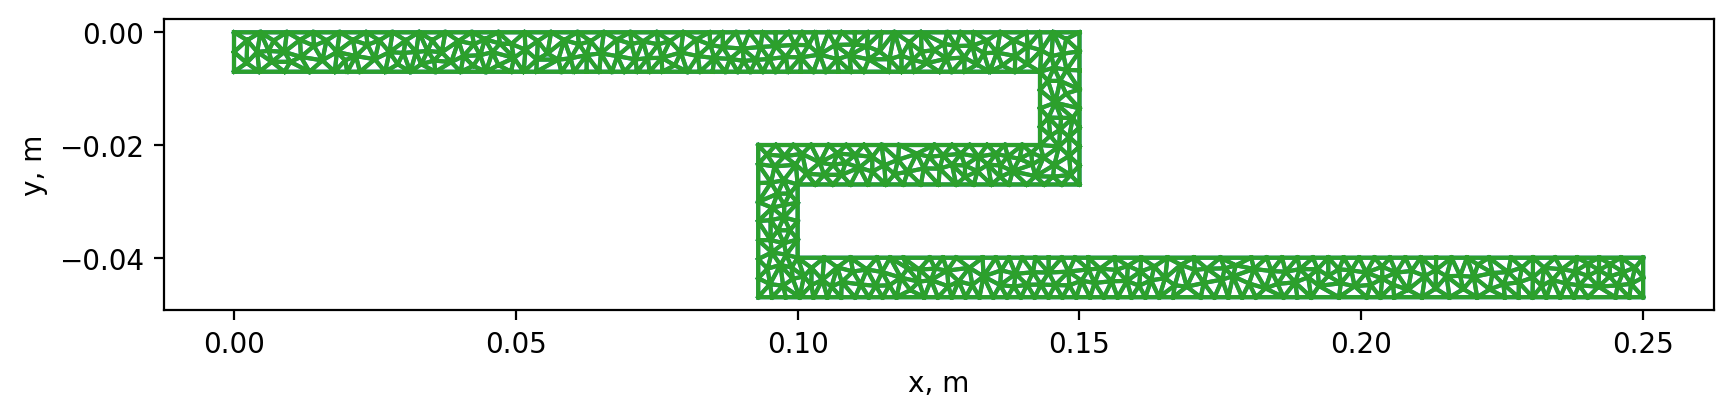

In [23]:
points, triangles = make_grid(0.007)
test_x_f = points[:,0]
test_y_f = points[:,1]

def plot1(u,v):
    plt.figure(figsize = (10, 10), dpi = 200)
    plt.triplot(u, v, triangles)
    plt.xlabel('x, m')
    plt.ylabel('y, m')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.draw()

plot(test_x_f, test_y_f)

* **(35pt)** Write a code that solves this problem by the finite element method and outputs the $y$-component of the deflection of this piece of material, to be precise, $v(250,2 S)$

In [14]:
def Solver(p,t, H):

    make_grid(H)
    
    E = 3.1*10**9
    nu = 0.35
    P = -0.2*9.81
    W = 3*10**(-3)
    S = 20*10**(-3)
    
    C11 = np.array([[E*(1-nu)/(1-2*nu)/(1+nu), 0],[0, E/2/(1+nu)]])
    C12 = np.array([[0, E*nu/(1-2*nu)/(1+nu)], [E/2/(1+nu), 0]])
    C21 = C12.T
    C22 = np.array([[E/2/(1+nu), 0], [0, E*(1-nu)/(1-2*nu)/(1+nu)]])
    
    N = p.shape[0]
    T = t.shape[0]
    
    A = np.zeros((2*N,2*N))
    b = np.zeros(2*N)

    for i in range(0,T):
        p1 = p[int(t[i,0]),:2] 
        p2 = p[int(t[i,1]),:2] 
        p3 = p[int(t[i,2]),:2] 
        
        verts = np.stack((p1, p2, p3))
        T_area = np.abs(np.linalg.det([[p2[0]-p1[0],p2[1]-p1[1]],[p3[0]-p1[0],p3[1]-p1[1]]])/2)

        # u != 0, p != 0
        for k in range(0,3):
            for j in range(0,3):
                k1 = (k+1)%3
                k2 = (k+2)%3
                j1 = (j+1)%3
                j2 = (j+2)%3

                grad1 = np.array([verts[k1,1]-verts[k2,1],verts[k2,0]-verts[k1,0]])
                grad1 = np.dot(C11, grad1)
                grad2 = np.array([[verts[j1,1]-verts[j2,1]],[verts[j2,0]-verts[j1,0]]])

                A[int(t[i,j]),int(t[i,k])] += 1./(4*T_area)*np.dot(grad1,grad2)[0]

        # u != 0, q != 0
        for k in range(0,3):
            for j in range(0,3):

                k1 = (k+1)%3
                k2 = (k+2)%3
                j1 = (j+1)%3
                j2 = (j+2)%3

                grad1 = np.array([verts[k1,1]-verts[k2,1],verts[k2,0]-verts[k1,0]])
                grad1 = np.dot(C12, grad1)
                grad2 = np.array([[verts[j1,1]-verts[j2,1]],[verts[j2,0]-verts[j1,0]]])

                A[int(t[i,j]),N + int(t[i,k])] += 1./(4*T_area)*np.dot(grad1,grad2)[0]

        # v != 0, p != 0
        for k in range(0,3):
            for j in range(0,3):

                k1 = (k+1)%3
                k2 = (k+2)%3
                j1 = (j+1)%3
                j2 = (j+2)%3

                grad1 = np.array([verts[k1,1]-verts[k2,1],verts[k2,0]-verts[k1,0]])
                grad1 = np.dot(C21, grad1)
                grad2 = np.array([[verts[j1,1]-verts[j2,1]],[verts[j2,0]-verts[j1,0]]])

                A[int(N + t[i,j]),int(t[i,k])] += 1./(4*T_area)*np.dot(grad1,grad2)[0]

        # v != 0, q != 0
        for k in range(0,3):
            for j in range(0,3):

                k1 = (k+1)%3
                k2 = (k+2)%3
                j1 = (j+1)%3
                j2 = (j+2)%3

                grad1 = np.array([verts[k1,1]-verts[k2,1],verts[k2,0]-verts[k1,0]])
                grad1 = np.dot(C22, grad1)
                grad2 = np.array([[verts[j1,1]-verts[j2,1]],[verts[j2,0]-verts[j1,0]]])

                A[int(N + t[i,j]),N + int(t[i,k])] += 1./(4*T_area)*np.dot(grad1,grad2)[0]
    

    x = np.where(p[:,0] == 0)
    for i in x:
        A[i, :] = 0
        A[:, i] = 0
        A[i, i] = 1

        A[i+N, :] = 0
        A[:, i+N] = 0
        A[i+N, i+N] = 1

    x = np.where(p[:,0] == 0.25)[0]
    bound_p = p[x]
    bound_ind = np.hstack((bound_p,[[i] for i in x]))
    bound_ind = bound_ind[bound_ind[:, 1].argsort()]
    for n in range(len(x) - 1):
        for k in range(2):
            b[N + int(bound_ind[n + k,2])] += 1/2 * P/H/W * np.abs(bound_ind[n, 1] - bound_ind[n+1,1])
    sol = np.linalg.solve(A, b)
    return sol[:N], sol[N:]

S = 0.02
u, v = Solver(points,triangles, 7*10**(-3))
x = np.where((points[:, 0] == 0.25) & (points[:,1] == -2*S))[0][0]
print('v(0.25,-2S) = ', f"{v[x]:.3f}", '(m)')

v(0.25,-2S) =  -0.038 (m)


* **(10pt)** For three sets of parameters, $S=20$, $W=3$, $H\in\{7,8,9\}$ (all in ${\rm mm}$) compute the displacement $v(250,2 S)$, $E = 3.1\cdot 10^9 {\rm Pa}$, $\nu=0.35$, $P = m\cdot g$, $m=200 {\rm grams}$, $g=-9810 {\rm mm}/{\rm s}^2$.

* **(Optional)** Plot the three solutions found. For that you need to change the coordinates of each of the mesh nodes from $(x,y)$ by $(x,y) + (u(x,y),v(x,y))$ and plot the displaced mesh

v(0.25,-2S) =  -0.038 (m), for H =  0.007 (m)
v(0.25,-2S) =  -0.033 (m), for H =  0.008 (m)
v(0.25,-2S) =  -0.029 (m), for H =  0.009 (m)


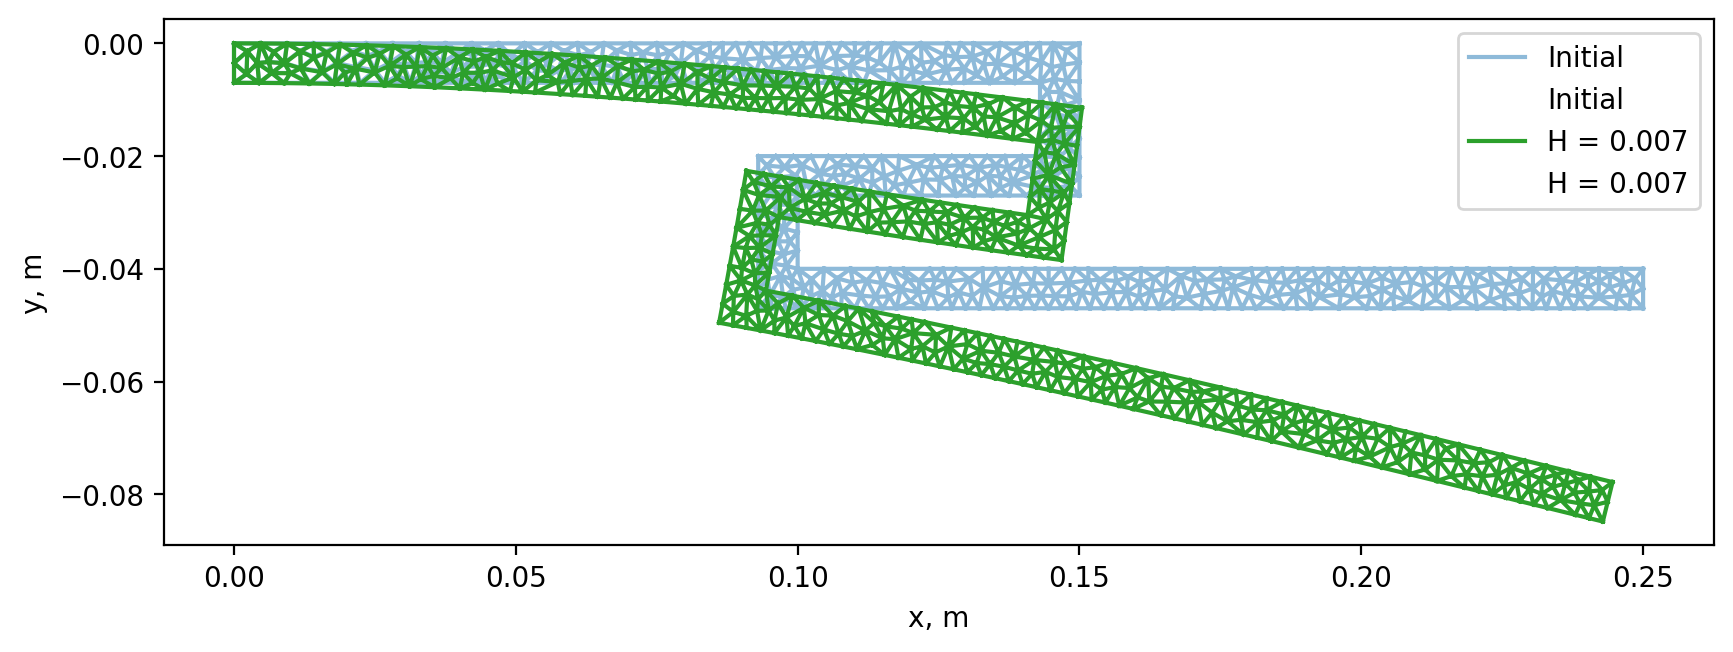

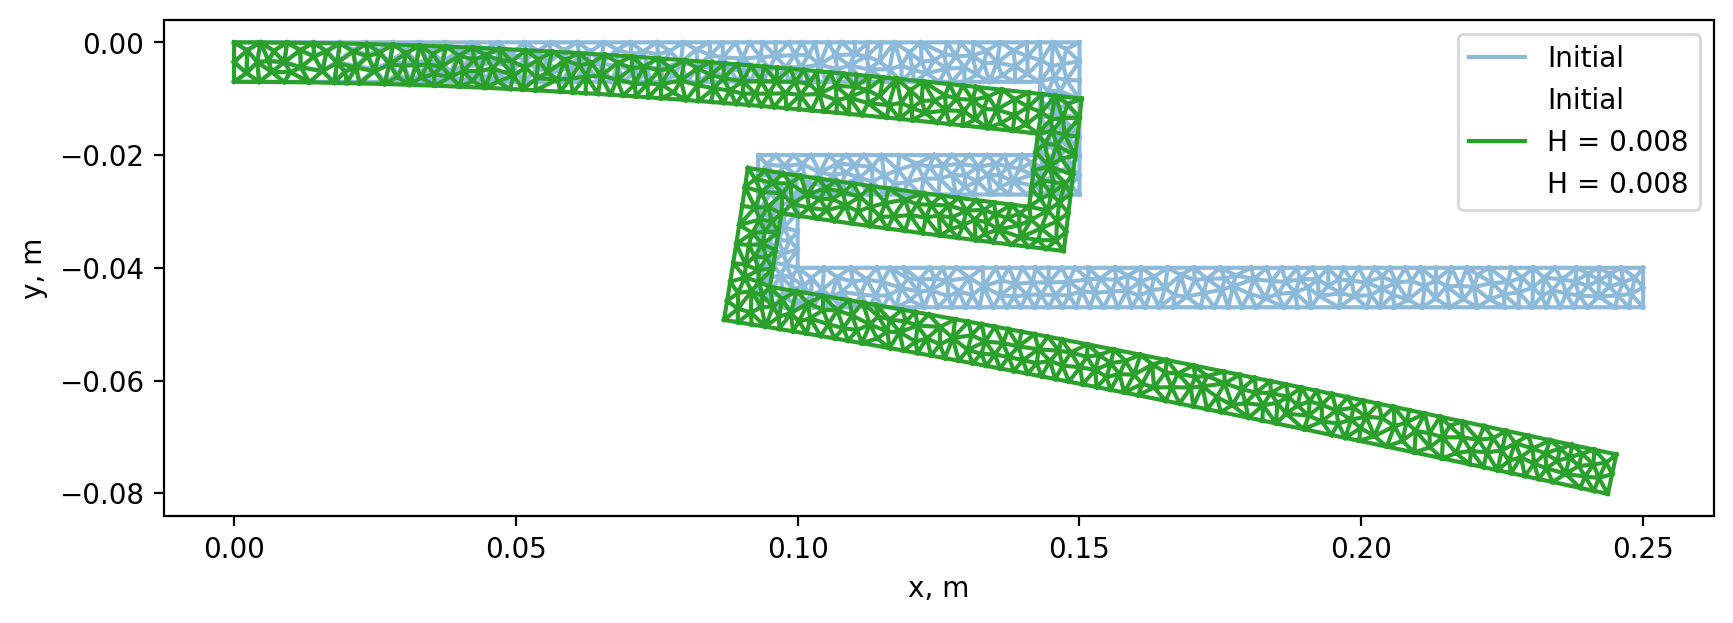

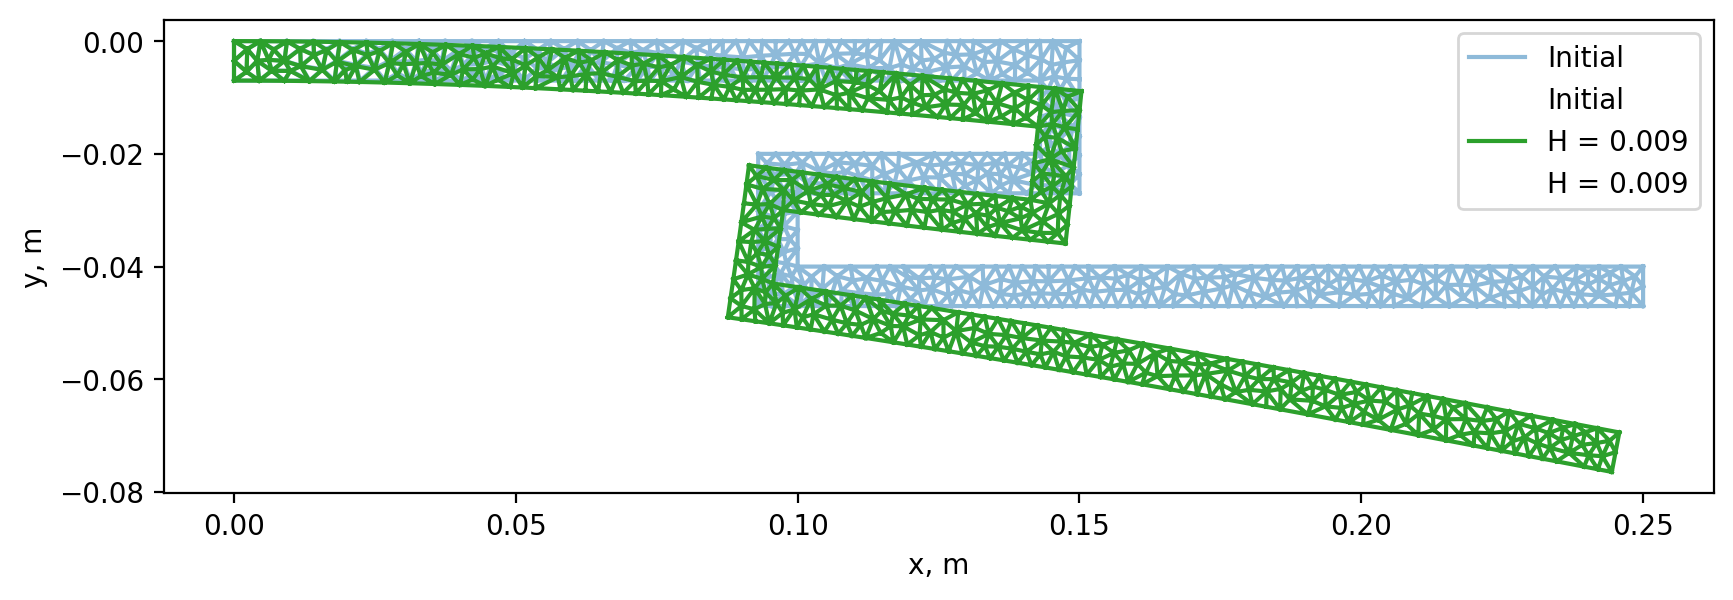

In [28]:
def plot(u,v, H):
    plt.figure(figsize = (10, 10), dpi = 200)
    plt.triplot(test_x_f, test_y_f, triangles, label = "Initial", alpha = 0.5)
    plt.triplot(u, v, triangles, label = f"H = {H:.3f}")
    plt.xlabel('x, m')
    plt.ylabel('y, m')
    plt.legend()
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.draw()

Hs = np.array([7., 8., 9.])*10**(-3)
for H in Hs:
    u, v = Solver(points,triangles, H)
    x = np.where((points[:, 0] == 0.25) & (points[:,1] == -2*S))[0][0]
    print('v(0.25,-2S) = ', f"{v[x]:.3f}", '(m), for H = ', f"{H:.3f}", '(m)')
    plot(test_x_f + u, test_y_f + v, H)